<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Graphs4Sci/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"><h1>Visualization for Science</h1>
<h1>Timerseries Map</h1>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

%matplotlib inline

Load default figure style

In [2]:
colors = [
 '#51a7f9',
 '#cf51f9',
 '#70bf41',
 '#f39019',
 '#f9e351',
 '#f9517b',
 '#6d904f',
 '#8b8b8b',
 '#810f7c']

## Johns Hopkins University Dataset

The JHU CoVID dataset has steadly become the unofficial standard dataset for the number of cases and deaths aroudn the world. You can download the continuously updated data from their [github repository](https://github.com/CSSEGISandData/COVID-19/):

In [3]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

The repository contains 4 time series files:

- time_series_covid19_confirmed_global.csv
- time_series_covid19_deaths_global.csv
- time_series_covid19_confirmed_US.csv
- time_series_covid19_deaths_US.csv

correponding to confirmed cases and number of deaths globally by country and for the US by state.

These curated files result from an aggregation and standardization of several dozen national health authority reports and have become the go-to 

## US Data



Now we take a detailed look at the situation within the US. The JHU github also has data for the US by state and county (admin2) level.

In [4]:
confirmed_US = pd.read_csv(url + 'time_series_covid19_confirmed_US.csv')

As in the case of the country level data, there are several other columns that we don't need

In [5]:
confirmed_US.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,7244,7244,7244,7244,7247,7247,7257,7257,7262,7262
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,21921,21945,21945,21945,21985,21985,22027,22027,22043,22043
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2344,2344,2344,2344,2345,2345,2346,2346,2347,2347
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2686,2686,2686,2686,2687,2687,2693,2693,2693,2693
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,6957,6967,6967,6967,6975,6975,6987,6987,6988,6988


We remove the extraneous columns

In [6]:
del_columns = [
 'UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key',
 'Admin2'
]

And aggregate at the state level.

In [7]:
confirmed_US.drop(columns=del_columns, inplace=True)
confirmed_US = confirmed_US.groupby('Province_State').sum().T
confirmed_US.index = pd.to_datetime(confirmed_US.index)

### Country Overview

A simply way of getting a quick overview of the situation in all the states is to include some degree of geographical information to plot the time series of all the states side by side. We opt to use a block map where each state is represented by an equal size square block where we can plot the time series.

We load the coordinates of each state from a csv file

In [8]:
states = pd.read_csv('https://raw.githubusercontent.com/DataForScience/Epidemiology101/master/data/states.csv', index_col=0)

And create a convenient dictionary to convert from state abbreviations to full state names

In [9]:
state_dict = dict(states.reset_index()[['index', 'name']].values)

And now we plot the time series for each state, normalized by the peak value, within each block. Further, we color the block based on the current value of the number of cases:

- Green, below 25% of the peak value
- Orange, between 25-75% of the peak value
- Red, above 75% of the peak value

as an indication of how well each state is doing.

In [10]:
confirmed_US = confirmed_US[:'2020']

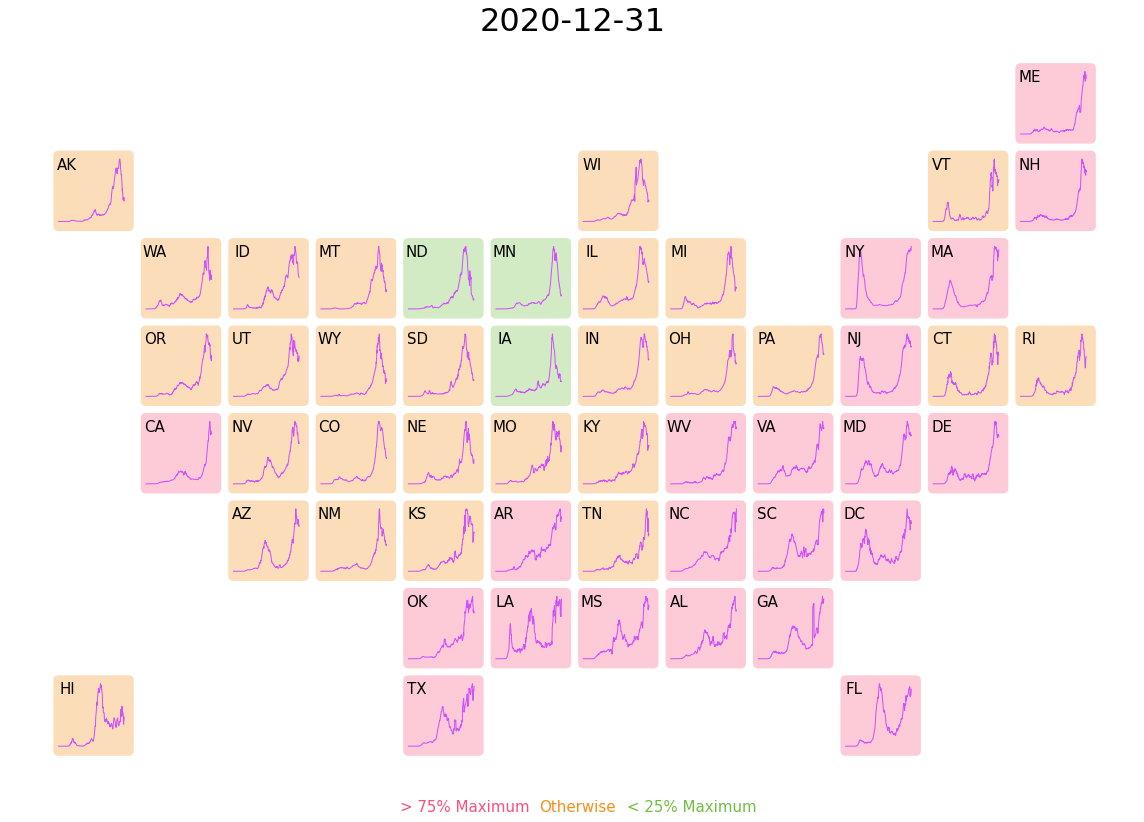

In [11]:
fig, ax = plt.subplots(1, figsize=(16, 22))
ax.set_aspect(1.)
ax.invert_yaxis()

patches = []
color_list = []

x = np.linspace(0., 0.75, confirmed_US.shape[0])

for state in states.index:
    daily = confirmed_US[state_dict[state]].diff(1).rolling(7).mean()
    
    timeline = (daily/daily.max()).fillna(0).values
    color = colors[3]
    
    if timeline[-1] > 0.75:
        color = colors[5]
    elif timeline[-1] < 0.25:
        color = colors[2]
    
    fancybox = mpatches.FancyBboxPatch([states.x[state]-0.5, 
                                        states.y[state]-0.5], 0.8, 0.8,
                                        boxstyle=mpatches.BoxStyle("Round", 
                                                                   pad=0.06))
    patches.append(fancybox)
    color_list.append(color)
    
    ax.text(y=states.y[state]-0.4, x=states.x[state]-0.4, 
            s=state, horizontalalignment='center', 
            verticalalignment='center', fontsize=15)
    ax.plot(states.x[state]+x-0.5, states.y[state]-timeline/1.4+0.25, 
            lw=1, color=colors[1])

collection = PatchCollection(patches, facecolors=color_list, alpha=0.3)
ax.add_collection(collection)

ax.text(x=3.4,y=8, s='> 75% Maximum', color=colors[5], fontsize=15, ha='left')
ax.text(x=5, y=8, s='Otherwise', color=colors[3], fontsize=15, ha='left')
ax.text(x=6, y=8, s='< 25% Maximum', color=colors[2], fontsize=15, ha='left')

ax.set_title(confirmed_US.index[-1].strftime('%Y-%m-%d'), fontsize=32)

ax.axis('off')
fig.patch.set_facecolor('#FFFFFF')
fig.tight_layout()

<div style="width: 100%; overflow: hidden;">
     <img src="https://raw.githubusercontent.com/DataForScience/Graphs4Sci/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>